In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Portfolio Optimization and Resource Estimation

$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

-----
## Overview



**What you'll do:**
* Setup a QUBO portfolio optimization problem
* Map the problem to a quantum Hamiltonian
* Solve the problem with a QAOA implementation in CUDA-Q
* Execute the QAOA workflow on a simulator and quantum hardware through AWS Braket
* Budget resources to run QAOA on quantum hardware


Pre-requisites: Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q. It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, Hamiltonians, and circuit sampling. The CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provides a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing.  While not required, the notebook titled "[Lab 1 - Overview: Max cut with QAOA on a small graph](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/01_Max-Cut-with-QAOA.ipynb)" provides additional context for the Quantum Approximate Optimization Algorithm (QAOA) covered here.

------

## Introduction

Portfolio optimization is foundational for modern finance. The aim of portfolio optimization is to select the best combination of assets to maximize returns while minimizing risk. Qualitatively, this looks like the portfolio in the leftmost point of the "universe" of potential portfolios pictured below. 


<img src="portfolioopt.png" alt="Drawing" style="width: 900px;"/>


Seminal to this field is Harry Markowitz's Modern Portfolio Theory (MPT), introduced in the 1950s. Markowitz's groundbreaking work established the framework for diversification, demonstrating that the risk of a portfolio is not merely the sum of the risks of its individual assets. Instead, by carefully selecting a mix of assets with varying correlations, investors can reduce the overall portfolio risk. 


Even with such insights, identifying good portfolios is extremely challenging when there are seeming endless choices for investment selections.  Moreover, fund managers can add additional complexity by changing the weights of each portfolio or considering schemes where stock inclusion is not binary, but can include a number of different strategies.

Regardless of the setup, the biggest challenge for portfolio optimization is the combinatorial scaling of the universe of potential portfolios. It is well within the bounds of practicality to consider, for example, a portfolio constructed from 20 Fortune 100 stocks which is selected from 100 choose 20 or quintillions ($10^{20}$) of potential portfolios. This is where quantum computing might be able to help. 

The idea is to encode the problem into a quantum state consisting of $n=100$ qubits. A clever algorithm could leverage the properties of superposition, entanglement, and interference to evolve this state towards a final state from which quality portfolios can be sampled with a high probability.  This avoids the need for brute force search of all $10^{20}$ portfolios and potentially provides a much more efficient means to sample optimal portfolios.

The simplest formulation of a portfolio optimization is an equal weighted quadratic unconstrained binary optimization (QUBO). The QUBO formulation is presented in the following equation.

$$\min_{x} (-\alpha x^T\mu + \beta x^T\sigma x) = \min_{x} (x^TQx) = \min_{x} (\sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j )$$

The $x$ vector is binary (1 or 0 entries) and is of length $n$ (total possible stocks) where the portfolio is indicated by the subset of 1 entries. The $\mu$ vector and $\sigma$ matrix contain information about the return of each stock and the covariance between pairs of stocks. This information is generally obtained from historical data which is an helpful but imperfect indicator of future behavior. Finally, the $\alpha$ and $\beta$ terms are  parameters that weigh the importance of risk and reward. 

**Exercise 1:**

Given the $\alpha$, $\beta$, $\mu$ and $\sigma$ values below, write code to produce the QUBO matrix $Q$.  Note, in practice, the matrix is usually made upper diagonal by doubling the upper diagonal entries and zeroing out the lower diagonal entries.  This saves space rather than having two terms correspond to the same correlation.

First run the cell below to load the necessary packages for this notebook.

In [ ]:
# Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Run this notebook in a CPU runtime
# Uncomment the lines below and execute the cell to install cuda-q

# !pip install cudaq

In [9]:
#pip install ipywidgets -q
import numpy as np
import itertools, math
import cudaq
from cudaq import spin 
from typing import List, Tuple
from itertools import combinations
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import defaultdict


In [10]:
# Run this cell to define helper functions
def top_k_bitstrings(shots, Q: np.ndarray, k: int = 5
                     ) -> List[Tuple[str, float, float]]:
    """
    List the k most-probable bit-strings in `shots` and their QUBO values.

    Returns
    -------
    [(bitstring, probability, qubo_cost), ...]
    """
    # ------------------------------------------------------------------
    # 1) extract a counts-dict {str -> int}
    # ------------------------------------------------------------------
    if isinstance(shots, dict):                        # plain counts dict
        counts_dict = shots
    elif hasattr(shots, "items"):                      # cudaq.SampleResult
        counts_dict = dict(shots.items())
    elif hasattr(shots, "counts"):                     # older naming
        counts_dict = shots.counts
    else:
        raise TypeError("Unrecognised shot container type.")

    total_shots = sum(counts_dict.values())
    if total_shots == 0:
        raise ValueError("No shots in sample result.")

    # ------------------------------------------------------------------
    # 2) sort by frequency and keep top-k
    # ------------------------------------------------------------------
    top = sorted(counts_dict.items(),
                 key=lambda kv: kv[1],
                 reverse=True)[:k]

    # ------------------------------------------------------------------
    # 3) compute QUBO value for every string
    # ------------------------------------------------------------------
    n = Q.shape[0]
    results = []
    for bitstr, cnt in top:
        # bitstr is already a string like '1010'
        x = np.fromiter(bitstr, dtype=int, count=n)
        cost = float(x @ (Q @ x))
        prob = cnt / total_shots
        results.append((bitstr, prob, cost))
        print(f"{bitstr}   prob = {prob:.3f}   QUBO = {cost:.6f}")

    return results

def plot_samples_histogram(sample1, sample2, solutions_data, title="Portfolio Comparison"):
    """
    Plot a histogram comparing two CUDAQ sample objects.
    
    Args:
        sample1: First CUDAQ sample object
        sample2: Second CUDAQ sample object
        solutions_data: List of tuples ((bit0, bit1, ...), objective_value)
        title: Plot title
    """
    # Sort solutions by objective value
    sorted_solutions = sorted(solutions_data, key=lambda x: x[1])
    
    # Create a mapping from bitstring tuples to their string representation
    bitstring_map = {tuple(bits): ''.join(str(b) for b in bits) for bits, _ in sorted_solutions}
    
    # Convert samples to dictionaries of counts
    counts1 = defaultdict(int)
    counts2 = defaultdict(int)
    
    # Extract counts from sample1
    for bitstring, count in sample1.items():
        bitstring_tuple = tuple(int(b) for b in bitstring)
        counts1[bitstring_tuple] = count
        
    # Extract counts from sample2
    for bitstring, count in sample2.items():
        bitstring_tuple = tuple(int(b) for b in bitstring)
        counts2[bitstring_tuple] = count
    
    # Get all unique bitstrings in order of objective value
    all_bitstrings = [bits for bits, _ in sorted_solutions]
    
    # Create x-axis labels with bitstring and objective value
    x_labels = [f"{bitstring_map[bits]}\n(obj: {val:.2f})" for bits, val in sorted_solutions]
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Set positions for bars
    x = np.arange(len(all_bitstrings))
    width = 0.35
    
    # Create bars with NVIDIA colors
    nvidia_green = '#76B900'  # NVIDIA green color
    counts1_values = [counts1.get(bits, 0) for bits in all_bitstrings]
    counts2_values = [counts2.get(bits, 0) for bits in all_bitstrings]
    
    # Plot bars with black and NVIDIA green
    bar1 = ax.bar(x - width/2, counts1_values, width, label='Initial State', color='black')
    bar2 = ax.bar(x + width/2, counts2_values, width, label='Final State', color=nvidia_green)
    
    # Find the transition point between good and bad portfolios
    good_portfolios = []
    bad_portfolios = []
    for i, (_, val) in enumerate(sorted_solutions):
        if val < 0:
            good_portfolios.append(i)
        else:
            bad_portfolios.append(i)
    
    # Add annotations for good and bad portfolios
    max_count = max(max(counts1_values or [0]), max(counts2_values or [0]))
    if max_count > 0:
        if good_portfolios:
            mid_good = good_portfolios[len(good_portfolios)//2]
            ax.text(mid_good, max_count * 0.95, "Good Portfolios", 
                ha='center', va='center', fontsize=12, fontweight='bold')
        
        if bad_portfolios:
            mid_bad = bad_portfolios[len(bad_portfolios)//2]
            ax.text(mid_bad, max_count * 0.95, "Bad Portfolios", 
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Customize plot
    ax.set_xlabel('Bitstring Configuration (Objective Value)', fontsize=12)
    ax.set_ylabel('Sample Count', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Improve legend
    ax.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=10)
    
    # Add grid and adjust layout
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return fig, ax


In [11]:
 # Exercise 1 Solution
mu = np.array([0.80, 0.70, 0.25, 0.20])          # expected returns
Sigma = np.array([[0.90, 0.45, 0.55, 0.10],      # variances / covariances
                  [0.45, 0.40, 0.30, 0.08],
                  [0.55, 0.30, 0.25, 0.05],
                  [0.10, 0.08, 0.05, 0.05]])
alpha, beta = 1.0, 1.0
n = len(mu)

def portfolio_to_qubo(mu, Sigma, alpha=1., beta=1.):
    """
    Convert financial data into a QUBO Matrix
    
    Args:
        mu (np.array): length n vector of portfolio returns
        Sigma (np.array): nxn matrix of portfolio pair covariances
        alpha (float): tunable parameter for valuing return
        beta (float): tunable parameter for valuing risk

    
    Returns:
        Q (np.array): upper triangular QUBO Matrix
    """
    
    #TODO Start
    n = len(mu)
    Q = np.zeros((n, n))
    for i in range(n):
        Q[i, i] = -alpha * mu[i] + beta * Sigma[i, i]
    for i, j in combinations(range(n), 2):
        Q[i, j] = 2.0 * beta * Sigma[i, j]
    return Q

Q = portfolio_to_qubo(mu, Sigma, alpha, beta)
print(Q)
#TODO End

[[ 0.1   0.9   1.1   0.2 ]
 [ 0.   -0.3   0.6   0.16]
 [ 0.    0.    0.    0.1 ]
 [ 0.    0.    0.   -0.15]]


Now, write a code that generates all of the possible portfolios, evaluates the portfolio quality by manually computing $x^TQx$, and returns the best portfolio.

In [12]:
# Solution
def evaluate_all_bitstrings(Q):
    """
    Evaluate QUBO objective x^T Q x for all possible bitstrings.
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        verbose (bool): Print all solutions if True
    
    Returns:
        best_x (np.array): Optimal bitstring
        best_val (float): Optimal objective value
        all_solutions (list): List of (bitstring, value) tuples
    """

    #TODO Start
    n = Q.shape[0]
    
    # Generate all possible bitstrings
    bitstrings = list(itertools.product([0, 1], repeat=n))
    
    # Evaluate each bitstring
    solutions = []
    best_val = float('inf')
    best_x = None
    worst_val = float('-inf')
    worst_x = None
    
    for bits in bitstrings:
        x = np.array(bits)
        val = float(x @ Q @ x)  # x^T Q x
        solutions.append((bits, val))
        
        if val < best_val:
            best_val = val
            best_x = x.copy()

        if val > best_val:
            worst_val = val
            worst_x = x.copy()
            
    
    # Sort solutions by objective value
    solutions.sort(key=lambda x: x[1])
    
    print("\nBest solution:")
    print(f"x* = {best_x}")
    print(f"Objective value = {best_val:.6f}")

    print("\nWorst solution:")
    print(f"x* = {worst_x}")
    print(f"Objective value = {worst_val:.6f}")

    #print("\nAll solutions:")
    #print(solutions)
    
    return best_x, best_val, worst_x, worst_val, solutions
    
best_x, best_val, worst_x, worst_val, all_solutions = evaluate_all_bitstrings(Q)
#TODO End


Best solution:
x* = [0 1 0 0]
Objective value = -0.300000

Worst solution:
x* = [1 1 1 1]
Objective value = 2.710000


Now explore the widget below that allows you to change $\alpha$ and $\beta$. Try the following scenarios. 

- $\alpha=3$ and $\beta =1$
- $\alpha=1$ and $\beta =2$

Can you rationalize the optimal portfolios produced by these settings?  Hint: study $\mu$ and $\sigma$.

<iframe src="https://nvidia.github.io/cuda-q-academic/quantum-applications-to-finance/images/QUBO_widget.html" width="800" height="600"></iframe>



## From QUBO to Spin Operator Hamiltonian

The QUBO is a useful format because it is well understood how to map a QUBO to a quantum Hamiltonian whose ground state corresponds to the QUBO solution.  In the following sections you will explore two ways to find the ground state, first using the quantum approximate optimization algorithm (QAOA), and the second using an adiabatic approach and CUDA-Q dyanmics.

The first step to running either of these methods is to derive the Ising Hamiltonian, $H_C$, which corresponds to the QUBO problem. Starting with the QUBO definition $\sum_i Q_{ii} x_i + \sum_{i<j} Q_{ij} x_i  x_j$, substitute the binary variables with spin variables so $x_i = \frac{1-z_i}{2}$. This results in 

$$ \frac{1}{2} \sum_i Q_{ii} (1-z_i) +  \frac{1}{4} \sum_{i<j} Q_{ij} (1 - z_i - z_j +z_iz_j) $$
$$ \frac{1}{2} \sum_i Q_{ii} -\frac{1}{2} \sum_i Q_{ii}z_i +  \frac{1}{4} \sum_{i<j} Q_{ij}  - \frac{1}{4} \sum_{i<j} Q_{ij} z_i - \frac{1}{4} \sum_{i<j} Q_{ij}  z_j + \frac{1}{4} \sum_{i<j} Q_{ij}z_iz_j$$


Grouping the terms results in a constant $C$ that can be dropped as it has no impact on the optimization.

$$C=  \frac{1}{2} \sum_i Q_{ii} + \frac{1}{4} \sum_{i<j} Q_{ij}   $$

We can further simplify things by grouping the single variable terms and the interacting terms:
$$H_C =\sum_{i,j} J_{ij}\, z_i z_j + \sum_i h_i\, z_i,$$
 where $h_i$ are the coefficients of the single variable terms and $J_{ij}$ are the coefficients of the interacting terms: 

$$ h_i  = \frac{-1}{2}Q_{ii}  - \frac{1}{4}\sum_{i<j} Q_{ij} - \frac{1}{4}\sum_{k<i} Q_{ki} $$

$$ J_{ij}  =  \frac{1}{4}Q_{ij}. $$



**Exercise 2:**


Using this derivation, write two functions to 1) build an Ising Hamiltonian and 2) produce a CUDA-Q spin operator Hamiltonian. The first function should take an upper triangular QUBO matrix as a numpy array and return a list of coefficients for the single variable terms, a flattened list of pairs of indices for the double variable terms, and a list of coefficients for the double variable terms.  Returning each as a separate list in this way makes them easy to input to CUDA-Q kernels later.

Write a second function that uses these inputs and constructs the Hamiltonian as a CUDA-Q spin operator object. Print the Hamiltonian to confirm it is correct.

In [13]:
# Exercise 2 Solution
def qubo_to_ising(Q, tol=1e-12):
    """
    Convert a QUBO matrix to an Ising Hamiltonian
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        tol (float): Cutoff for near zero terms
    
    Returns:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    """
    #TODO Start
    n = Q.shape[0]
    
    # two-body 
    J_pairs, J_coeffs = [], []
    for i, j in combinations(range(n), 2):
        coeff = 0.25 * Q[i, j]
        if abs(coeff) > tol:
            J_pairs.extend([i, j])       
            J_coeffs.append(float(coeff))
    
    # one-body
    h = np.empty(n, dtype=float)

    # diagonal contributions
    for i in range(n):

        h[i] += -0.5 * Q[i,i]  #diagonal

        for j in range(n):     # linear z_i terms (sum terms in same row)

            if j > i:

                h[i] += -0.25 * Q[i,j]

        for k in range(i):    # linear z_i terms (sum terms in same column)


            if k < i:

                h[i] += -0.25 * Q[k,i]
    
    return h.tolist(), J_pairs, J_coeffs

h_list, pair_inds, J_list =    qubo_to_ising(Q) 

print(h_list)
print(pair_inds)
print(J_list)


def ising_to_spinop(h, pair_inds, J, n_qubits):
    """
    Creates a CUDA-Q SpinOperator Hamiltonian
    
    Args:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        H (cudaq.spinop): SpinOperator QUBO Hamiltonian
    """
    H = cudaq.SpinOperator()
    for i, coeff in enumerate(h):
        if coeff: H += coeff * spin.z(i)
    for k, coeff in enumerate(J):
        i, j = pair_inds[2*k : 2*k+2]
        H += coeff * spin.z(i) * spin.z(j)
    return H

H = ising_to_spinop(h_list, pair_inds, J_list, n)
print(H)

#TODO END

[-0.6000000000000001, -0.265, -0.45000000000000007, -0.039999999999999994]
[0, 1, 0, 2, 0, 3, 1, 2, 1, 3, 2, 3]
[0.225, 0.275, 0.05, 0.15, 0.04, 0.025]
(-0.6+0i) * Z0 + (-0.265+0i) * Z1 + (-0.45+0i) * Z2 + (-0.04+0i) * Z3 + (0.225+0i) * Z0Z1 + (0.275+0i) * Z0Z2 + (0.05+0i) * Z0Z3 + (0.15+0i) * Z1Z2 + (0.04+0i) * Z1Z3 + (0.025+0i) * Z2Z3


## Gate-Based Approach - QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical approach to solving combinatorial optimization problems. To the $|\!+\rangle^{\otimes n}$ state, it applies alternating layers of two types of unitary operations &mdash; one driven by a cost Hamiltonian (what your defined in the previous exercise) and one driven by a mixer Hamiltonian, each controlled by adjustable parameters. Your cost Hamiltonian is written as:

$$
H_C = \sum_{i,j} J_{ij}\, Z_i Z_j + \sum_i h_i\, Z_i,
$$

The goal is to produce a state, that when sampled, produces bitstrings at or close to the ground state of the Hamiltonian (i.e., optimal portfolios).
The QAOA state after $p$ iterations (layers) is:
$$
|\psi(\boldsymbol{\gamma}, \boldsymbol{\beta})\rangle 
= U_M(\beta_p)\,U_C(\gamma_p)\,\cdots\,U_M(\beta_1)\,U_C(\gamma_1)\,|\!+\rangle^{\otimes n},
$$

where:
- $U_C(\gamma_k) = e^{-i \gamma_k H_C}$ (cost unitary),  
- $U_M(\beta_k) = e^{-i \beta_k H_M}$ (mixer unitary, often chosen as a transverse-field Hamiltonian),  
- $|\!+\rangle^{\otimes n}$ is the uniform superposition over all computational basis states,  
- and $\gamma_k, \beta_k$ are the variational parameters over the $p$ layers.

A classical optimizer iteratively updates these parameters to minimize the following expectation value: $$\langle \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) | H_C | \psi(\boldsymbol{\gamma}, \boldsymbol{\beta}) \rangle.$$

**Exercise 3:**

Code a QAOA kernel in CUDA-Q. Note how inputs are provided as lists in accordance with your earlier functions. The figure below shows the gates applied to two qubits and one layer of the QAOA circuit.
Specifically, the elements of the cost function are applied as $R_Z$ gates parameterized with a $\gamma$ for each layer, times $h_i$ for the single variable terms. The two variable terms are applied as a CNOT gate between the two corresponding qubits (controlled by the first), an $R_Z$ gate parameterized with the same $\gamma$ for each layer, times $J_{ij}$, followed by a repeat of the previous CNOT gate. The mixer terms are simple $R_X$ gates applied to each qubit parameterized with a $2.0*\beta$ for each layer.

<img src="qaoa-subcircuit.png" alt="Drawing" style="width: 900px;"/>

In [14]:
# Exercise 3 Solution
@cudaq.kernel
def qaoa_kernel(theta : list[float],
                qubit_count : int,
                layers : int,
                h_coeffs : list[float],
                pair_inds : list[int],
                J_coeffs : list[float]):

    """
    Creates a CUDA-Q kernel corresponding to a QAOA circuit
    
    Args:
        theta (list): list of the variational parameters
        qubit_count (int): number of qubits
        layers (int): number of qaoa layers
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        (cudaq.kernel): QAOA kernel
    """

    #TODO Start
    q = cudaq.qvector(qubit_count)

    # Hadamards
    for idx in range(qubit_count):
        h(q[idx])

    for layer in range(layers):
        gamma = theta[layer]
        beta  = theta[layer + layers]

        # cost e^{-i γ H_C}
        # single-Z
        for i in range(qubit_count):
            coeff = h_coeffs[i]
            if coeff != 0.0:
                rz(2.0 * gamma * coeff, q[i])

        # ZZ
        num_pairs = len(J_coeffs)          # compile-time constant
        for k in range(num_pairs):
            i = pair_inds[2 * k]
            j = pair_inds[2 * k + 1]
            coeff = J_coeffs[k]

            cx(q[i], q[j])
            rz(2.0 * gamma * coeff, q[j])
            cx(q[i], q[j])

        # mixer e^{-i β ∑ X}
        for i in range(qubit_count):
            rx(2.0 * beta, q[i])
     #TODO END
     
 
@cudaq.kernel
def qaoa_kernel_with_measurement(theta : list[float],
                qubit_count : int,
                layers : int,
                h_coeffs : list[float],
                pair_inds : list[int],
                J_coeffs : list[float]):

    """
    Creates a CUDA-Q kernel corresponding to a QAOA circuit
    
    Args:
        theta (list): list of the variational parameters
        qubit_count (int): number of qubits
        layers (int): number of qaoa layers
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        (cudaq.kernel): QAOA kernel
    """

    #TODO Start
    q = cudaq.qvector(qubit_count)

    # Hadamards
    for idx in range(qubit_count):
        h(q[idx])

    for layer in range(layers):
        gamma = theta[layer]
        beta  = theta[layer + layers]

        # cost e^{-i γ H_C}
        # single-Z
        for i in range(qubit_count):
            coeff = h_coeffs[i]
            if coeff != 0.0:
                rz(2.0 * gamma * coeff, q[i])

        # ZZ
        num_pairs = len(J_coeffs)          # compile-time constant
        for k in range(num_pairs):
            i = pair_inds[2 * k]
            j = pair_inds[2 * k + 1]
            coeff = J_coeffs[k]

            cx(q[i], q[j])
            rz(2.0 * gamma * coeff, q[j])
            cx(q[i], q[j])

        # mixer e^{-i β ∑ X}
        for i in range(qubit_count):
            rx(2.0 * beta, q[i])
    mz(q)
     #TODO END

Test your kernel with the code below which computes an expectation value from the state produced by the circuit and feeds the result into a classical optimizer which optimizes the $\gamma$'s and the $\beta$'s. Then, the `shots` variable saves the results from sampling the circuit. Was the optimal portfolio the most probable?  

Sampling QAOA with initial parameters: { 0000:3128 0001:3129 0010:3124 0011:3030 0100:3132 0101:3181 0110:3180 0111:3045 1000:3206 1001:3154 1010:3182 1011:3107 1100:3088 1101:3100 1110:3104 1111:3110 }

QAOA results
   Normal return from subroutine COBYLA

 [-0.76388582  0.00227145  0.28439222  0.92658456  0.28208924 -0.64316485]
Sampling results of QAOA using the optimal parameters: { 0000:10799 0001:11390 0010:3905 0011:3399 0100:7579 0101:6039 0110:783 0111:459 1000:3107 1001:2080 1010:18 1011:44 1100:120 1101:23 1110:143 1111:112 }

Most-probable bit-string : 0001
   NFVALS =   72   F =-6.624076E-01    MAXCV = 0.000000E+00
   X =-7.638858E-01   2.271454E-03   2.843922E-01   9.265846E-01   2.820892E-01
      -6.431648E-01


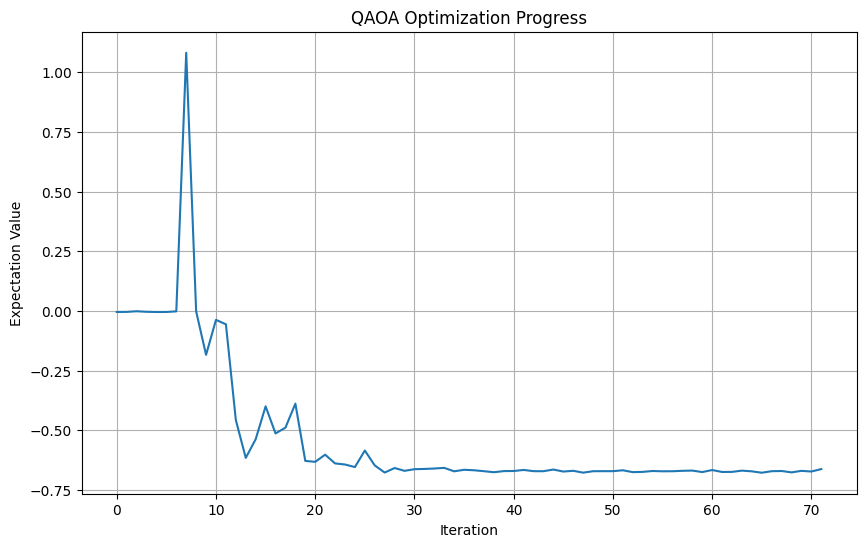

In [15]:
cudaq.set_target('qpp-cpu')    # Use the 'qpp-cpu' cpu simulator

shots_count = 50000 # number of samples to draw from the circuit during optimization loops
max_iter = 200 # maximum number of optimizer iterations
sample_count = 50000 # number of samples to draw from the circuit with optimal parameters

layers = 3

# set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

# select initial parameters
init = rng.uniform(0, 0, 2*layers)

initial= cudaq.sample(qaoa_kernel_with_measurement, init, n, layers,  # Sample results from initial state with all 0 parameters
                     h_list, pair_inds, J_list, shots_count=shots_count)

print('Sampling QAOA with initial parameters:',initial)


def run_qaoa(shots_count, max_iter, sample_count, max_shots, initial): 
    if shots_count*max_iter + sample_count > max_shots:
        print(f"Total shots {shots_count*max_iter + sample_count} exceed maximum allowed {max_shots}. Please adjust parameters.")
        return
    else:
        cost_history = []

        def qaoa_cost(theta):
            res = cudaq.observe(qaoa_kernel, H, theta, n, layers,
                        h_list, pair_inds, J_list, shots_count=shots_count)
            cost = res.expectation()
            cost_history.append(cost)
    
            return cost

        opt_result = minimize(qaoa_cost, init, method='COBYLA',
                            options={'maxiter': max_iter, 'disp': True})

        print('QAOA results', opt_result.x)

        shots = cudaq.sample(qaoa_kernel_with_measurement, opt_result.x, n, layers,
                        h_list, pair_inds, J_list, shots_count=sample_count)

        print('Sampling results of QAOA using the optimal parameters:', shots)
        print('Most-probable bit-string :', np.array(shots.most_probable()).astype(str))

        plt.figure(figsize=(10, 6))
        plt.plot(cost_history)
        plt.xlabel('Iteration')
        plt.ylabel("Expectation Value")
        plt.title('QAOA Optimization Progress')
        plt.grid(True)
        plt.show()
        
        return shots
    
shots = run_qaoa(shots_count, max_iter, sample_count, 20000000, init)  

The QAOA result may not produce the optimal portfolio most frequently due to the *approximate* nature of QAOA.  However, the resulting QAOA state should sample the optimal portfolio with much higher probability than randomly sampling all bitstrings. Run the script below on the sample results and confirm that the optimal portfolio is at least in the top 5 results sampled from the QAOA procedure.

In [16]:
# Enter a CUDA-Q Sampleresult, Q, and the number of top bistrings to list
top5 = top_k_bitstrings(shots, Q, k=5) 

0001   prob = 0.228   QUBO = -0.150000
0000   prob = 0.216   QUBO = 0.000000
0100   prob = 0.152   QUBO = -0.300000
0101   prob = 0.121   QUBO = -0.290000
0010   prob = 0.078   QUBO = 0.000000


This variability can make it challenging to assess a particular optimization method. For example, what if you run QAOA and produce a state that only samples the second best portfolio?   If there are quintillions of portfolios, that is not too bad!  Result quality for simulated quantum algorithms is often quantified with a so called approximation ratio.  This ratio can be defined a few ways, but the idea is to see how close the result is to the optimal portfolio.

A pragmatic way to do this is take the best result from the sample and compare it to the optimal value. For a small problem like you completed, that will probably be trivially 1 as you sample the optimal state many times. A better estimate to assess the algorithm performance is the average sample result divided by the optimal value.  This approach can also help prove that the QAOA procedure really did help produce a state that samples better portfolios and that you did not just get lucky sampling the ground state. 

To better visualize the performance of your QAOA function, use the `plot_samples_histogram` function to plot a sample from the QAOA kernel with your initial parameters (a uniform superposition as all variational parameters are 0) and the final state you produced.  Did the algorithm work?  

Note, `plot_samples_histogram` takes the initial and final CUDA-Q sample results as inputs, as well as the list of all solutions output by the `evaluate_all_bitstrings` function you wrote previously.

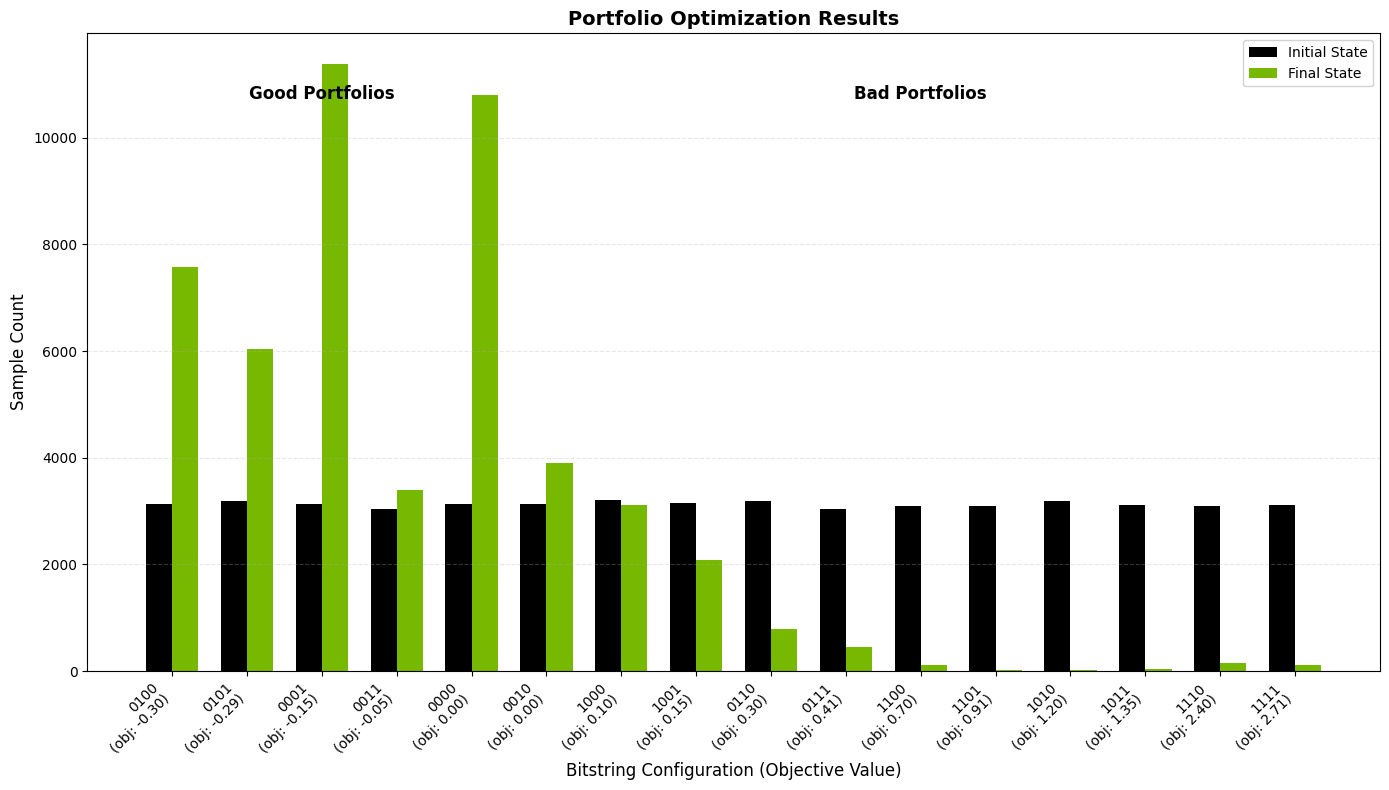

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

fig, ax = plot_samples_histogram(initial, shots, all_solutions, 
                                "Portfolio Optimization Results")
plt.show()

Assume you are a portfolio manager and you need to be confident that you are suggesting a portfolio that has more reward than risk (a negative cost function value in this case).  From the histogram, estimate the probability of choosing a good portfolio from the initial solution and your QAOA solution?  

## Resource Estimation and Quantum Hardware

While simulating our small example on a CPU allowed us to operate in a perfect, noise-free environment with a high number of shots, executing algorithms on actual quantum hardware requires a more strategic approach. We now face two major real-world challenges: inherent device noise and finite computational resources. 

Given that your allocation for this workshop is 5000 shots, we must now shift our focus from theoretical performance to practical, resource-aware implementation. 

 **Exercise 4** In the cell block below use the cpu-simulator to optimize how you would allocate your 5000 shots amongst the different portions of the workflow.  What other parameters might affect performance?

QAOA results [1. 0. 0. 0. 0. 0.]
Sampling results of QAOA using the optimal parameters: 
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    5   F =-2.820000E-02    MAXCV = 0.000000E+00
   X = 1.000000E+00   0.000000E+00   0.000000E+00   0.000000E+00   0.000000E+00
       0.000000E+00
{ 0000:67 0001:82 0010:67 0011:69 0100:62 0101:57 0110:53 0111:63 1000:66 1001:58 1010:59 1011:52 1100:51 1101:60 1110:60 1111:74 }

Most-probable bit-string : 0001


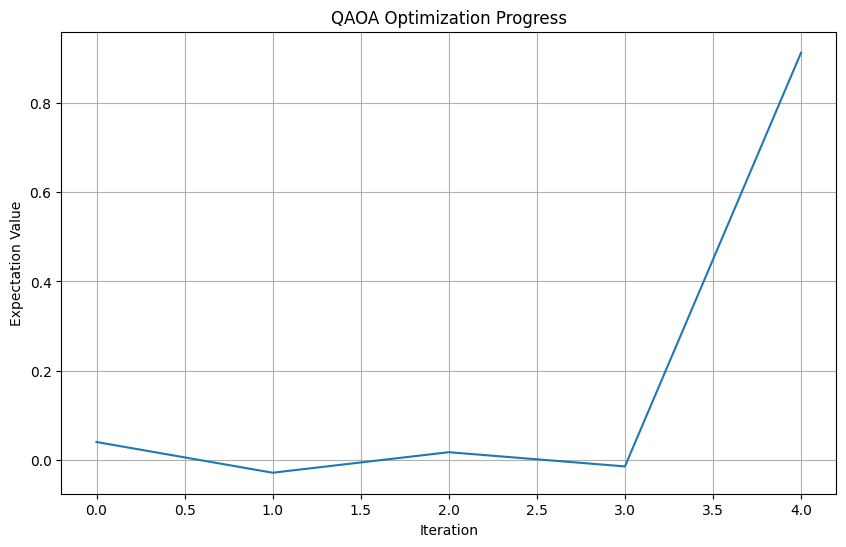

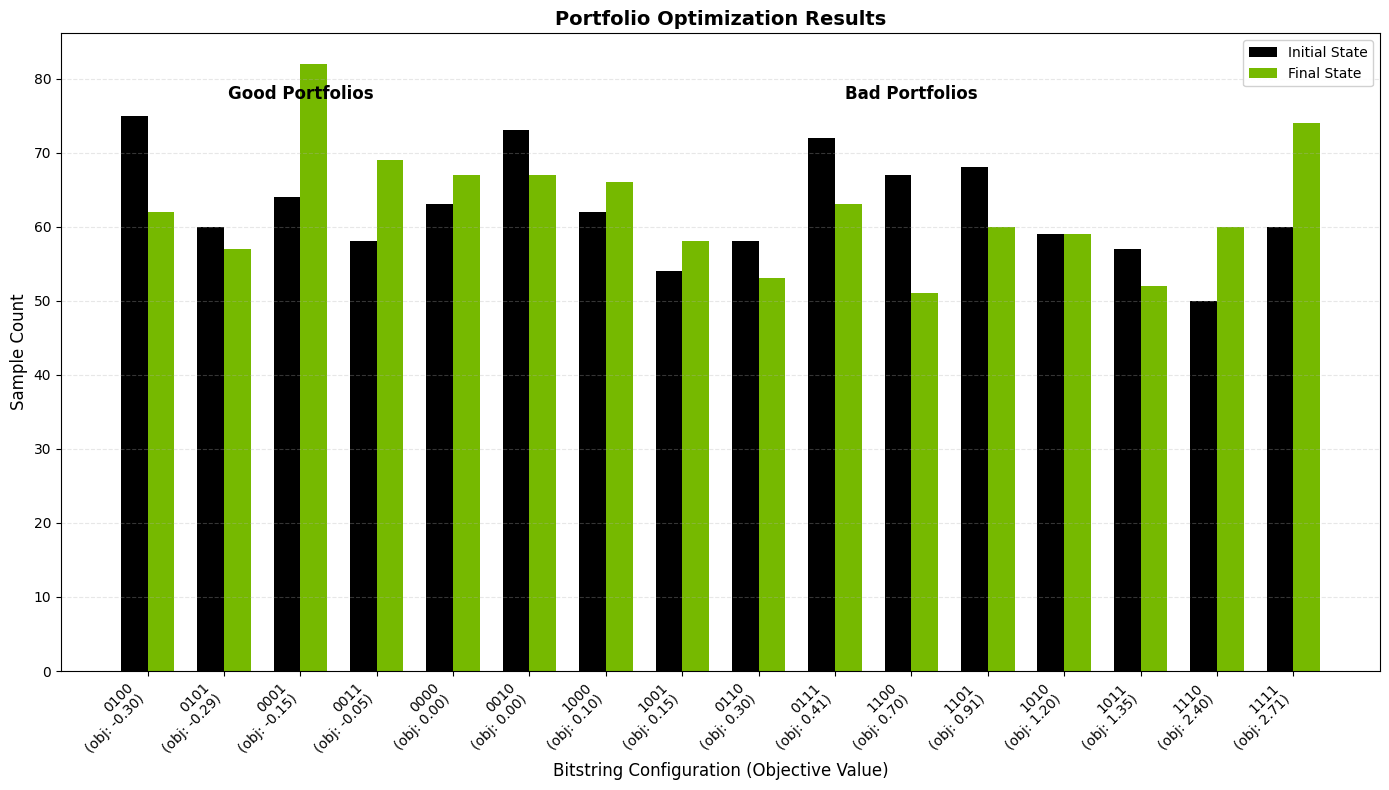

In [33]:
# Exercise 4 Part 1 TODO
# Experiment with different values of the following parameters to fit within your quantum hardware constraints
# Test these values on a simulator first to see how they affect the optimization results
import numpy as np
shots_count = 800 # number of samples to draw from the circuit during expectation value calculations
max_iter = 5 # maximum number of optimizer iterations
sampling_count = 1000 # number of samples to draw from the circuit with optimal parameters
initial_parameters = np.random.uniform(0, 0, 2*layers) # experiment with warm starting the QAOA with different initial parameters

shots = run_qaoa(shots_count, max_iter, sampling_count, max_shots = 5000, initial=initial_parameters)

if shots is not None:
    initial_sample= cudaq.sample(qaoa_kernel_with_measurement, initial_parameters, n, layers,  # Sample results from initial state with all 0 parameters
                     h_list, pair_inds, J_list, shots_count=sampling_count)
    fig, ax = plot_samples_histogram(initial_sample, shots, all_solutions, 
                                "Portfolio Optimization Results")
    plt.show()

In [36]:
# Exercise 4 Part 2 TODO
# Now change the target to the quantum hardware you will be using
arn = "arn:aws:braket:us-east-1::device/qpu/ionq/Forte-Enterprise-1" # Copy your ARN from the AWS Braket console
cudaq.set_target("braket", machine = arn)

# Run the QAOA workflow with the parameters that you determined worked best within your hardware constraints
shots = run_qaoa(shots_count, max_iter, sampling_count, max_shots = 5000, initial = initial_parameters)

RuntimeError: Braket task arn:aws:braket:us-east-1:503720606224:quantum-task/53f54c19-e388-4c49-84c2-1007387df1d3 terminated without results. 

How do the results from the quantum hardware differ from the cpu simulation?  Why might the results differ?

## Summary and Further Directions

You have now successfully learned how to use CUDA-Q to solve portfolio optimization problems and more generally, any problem that can be formulated as a QUBO! 🎉 

Though the example in this lab is small, it can be easily scaled up.  In fact, the same approach used in "[Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut)" can potentially be used here to divide the problem into sub QAOA problems which can be solved in parallel and then knit together to obtain the final results. However, this depends on the sparsity of the QUBO and can only be used if certain stocks have negligible covariance.

Another possible approach is to use AI.  Rather than performing the QAOA optimization loop to identify an optimal set of parameters and produce the circuit corresponding to the ground state, techniques like [QAOA-GPT](https://arxiv.org/abs/2504.16350) can use a generative model to generate the final QAOA circuit to sample, completely bypassing the optimization loop.  Such an approach has promise, but is highly dependent on quality training data such that generated circuits are good approximations for the ground state.

You can look consider further extensions of this tutorial in the "[Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb)" notebook in the CUDA-Q Academic applications to finance series. In that notebook you will learn how to solve the portfolio optimization using different quantum methods, add constraints, and explore methods for scaling up such approaches. This notebook also explores the state-of-the-art Q-CHOP algorithm developed by Infleqtion (also contributors to this notebook) and JPMorgan Chase demonstrating how the fundamental examples you code up with CUDA-Q can be extended towards useful real-world applications.

Finally, in today's tutorial we only used noise free simulators.  To get a better resource estimation for using noisy quantum hardware, it would be better to use a noisy simulator.  To learn more about noisy simulations using CUDA-Q, check out [the noisy simulator notebook.](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/03_QEC_Noisy_Simulation.ipynb)
